In [15]:
import winsound
import os

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\
                          , auc, accuracy_score, classification_report

import matplotlib.pyplot as py
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.inception_resnet_v2 import InceptionResNetV2

import keras_tuner
from kerastuner.tuners import RandomSearch

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    pass

In [3]:
image_size = (299, 299) # must tuple of 3D for keras
seed = 45
path = "DataSet-Handle/"

In [4]:
# Load Images and make augmentation 
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True) 

# loading...
train_it = datagen.flow_from_directory(path + "Train", class_mode='categorical', seed=seed, 
              color_mode='grayscale', target_size = image_size)

valid_it = datagen.flow_from_directory(path + "Validation", class_mode='categorical', seed=seed, 
              color_mode='grayscale', target_size = image_size)

test_it = datagen.flow_from_directory(path + "Test", class_mode='categorical', seed=seed, 
              color_mode='grayscale', target_size = image_size)

Found 30482 images belonging to 4 classes.
Found 10246 images belonging to 4 classes.
Found 8215 images belonging to 4 classes.


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
def build_model(): 
    inputs = tf.keras.Input(shape= image_size + (1,))
    
    x = layers.BatchNormalization()(inputs)
    
    x = layers.Conv2D(16,5)(x)
    x = layers.Activation(tf.nn.relu)(x)
    x = layers.MaxPooling2D((4,4))(x)
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Conv2D(16,5)(inputs)
    x = layers.Activation(tf.nn.relu)(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Conv2D(8,5)(inputs)
    x = layers.Activation(tf.nn.relu)(x)
    x = layers.MaxPooling2D((4,4))(x)
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.3)(x)   
    x = layers.Dense(128, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(8, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(4, activation=tf.nn.gelu)(x)

    model = tf.keras.Model(inputs, output)
    
    model.compile(
        optimizer= tf.keras.optimizers.SGD(0.01),
        loss= tf.keras.losses.CategoricalCrossentropy(),
        metrics= [tf.keras.metrics.CategoricalAccuracy(), 
                  tf.keras.metrics.AUC()])
    
    return model

In [11]:
model = build_model()

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 295, 295, 8)       208       
                                                                 
 activation_5 (Activation)   (None, 295, 295, 8)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 8)        0         
 2D)                                                             
                                                                 
 rescaling_5 (Rescaling)     (None, 73, 73, 8)         0         
                                                                 
 flatten_1 (Flatten)         (None, 42632)             0         
                                                             

In [13]:
hist = model.fit_generator(train_it, epochs=5, steps_per_epoch=5,validation_data=valid_it)

C:\Users\ABO ELKHEIR\AppData\Local\Temp\ipykernel_2372\2859859429.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_it, epochs=5, steps_per_epoch=5,validation_data=valid_it)


Epoch 1/5
5/5 [==============================] - 342s 84s/step - loss: 3.4686 - categorical_accuracy: 0.2875 - auc: 0.5068 - val_loss: 1.8179 - val_categorical_accuracy: 0.2522 - val_auc: 0.5000
Epoch 2/5
5/5 [==============================] - 87s 21s/step - loss: 2.5514 - categorical_accuracy: 0.2250 - auc: 0.5051 - val_loss: 1.6471 - val_categorical_accuracy: 0.2522 - val_auc: 0.5000
Epoch 3/5
5/5 [==============================] - 88s 22s/step - loss: 1.7784 - categorical_accuracy: 0.2313 - auc: 0.5167 - val_loss: 1.6277 - val_categorical_accuracy: 0.2522 - val_auc: 0.5000
Epoch 4/5
5/5 [==============================] - 97s 24s/step - loss: 2.4179 - categorical_accuracy: 0.2500 - auc: 0.4979 - val_loss: 1.6114 - val_categorical_accuracy: 0.2522 - val_auc: 0.5000
Epoch 5/5
5/5 [==============================] - 89s 22s/step - loss: 2.1830 - categorical_accuracy: 0.2740 - auc: 0.5114 - val_loss: 1.5974 - val_categorical_accuracy: 0.2522 - val_auc: 0.5000


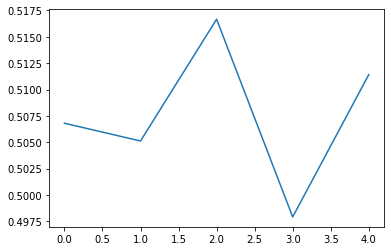

In [17]:
py.plot(hist.history['auc'])

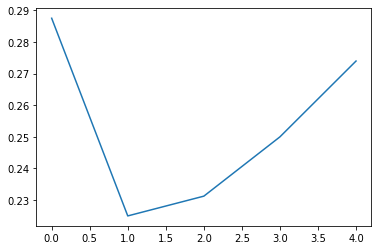

In [19]:
py.plot(hist.history['categorical_accuracy'])

In [20]:
model.evaluate_generator(valid_it)

C:\Users\ABO ELKHEIR\AppData\Local\Temp\ipykernel_2372\345970593.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(valid_it)


[1.597363829612732, 0.25219598412513733, 0.5]

In [21]:
model.evaluate_generator(test_it)

C:\Users\ABO ELKHEIR\AppData\Local\Temp\ipykernel_2372\385855088.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_it)


[1.5978889465332031, 0.25429093837738037, 0.5]

C:\Users\ABO ELKHEIR\AppData\Local\Temp\ipykernel_2372\2057135174.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model_pre = model.predict_generator(test_it)


Classification Report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00      2026
           1       0.00      0.00      0.00      2089
           2       0.25      1.00      0.41      2089
           3       0.00      0.00      0.00      2011

    accuracy                           0.25      8215
   macro avg       0.06      0.25      0.10      8215
weighted avg       0.06      0.25      0.10      8215

Accuracy :  0.2542909312233719


C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\gpu2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


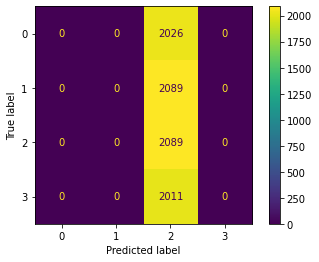

In [22]:
model_pre = model.predict_generator(test_it)

model_pre = [np.argmax(i) for i in model_pre]
print("Classification Report : ", classification_report(test_it.classes, model_pre))
print("Accuracy : ", accuracy_score(test_it.classes, model_pre))
ConfusionMatrixDisplay(confusion_matrix(test_it.classes, model_pre)).plot()